## Visualise the Fourier Transform below

<img src="https://upload.wikimedia.org/wikipedia/commons/6/61/FFT-Time-Frequency-View.png" alt="Fourier Transform" height="400"/>

<img src="../assets/ft.jpg" alt="Fourier Transform" height="400"/>

## Fourier Transform

$$
X(f) = \int_{-\infty}^{\infty} x(t) e^{-j\omega t} dt
$$

## Inverse Fourier Transform

$$
x(t) = \int_{-\infty}^{\infty} X(f) e^{j\omega t} df
$$

# Quantum Fourier Transform (QFT)

In this tutorial, we QFT, derive the circuit, and implement it using Qiskit. We show how to run QFT on a simulator and a five qubit device

## 1. Introduction <a id='introduction'></a>

The Fourier transform occurs in many different versions throughout classical computing, in areas ranging from signal processing to data compression to complexity theory. The QFT is the quantum implementation of the discrete Fourier transform over the amplitudes of a wavefunction. It is part of many quantum algorithms, most notably Shor's factoring algorithm and quantum phase estimation. 

The discrete Fourier transform acts on a vector $(x_0, ..., x_{N-1})$ and maps it to the vector $(y_0, ..., y_{N-1})$ according to the formula


$$y_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}x_j e^{2\pi i \frac{jk}{N}}$$

> Notice how as long as $\sum_{-\infty}^{\infty} |x_j|$, is cauchy convergent, we can substitute $\omega = \frac{2\pi k}{N}$ and get back the continuous Fourier Transform in the limit as $N \to \infty$


Note that only the amplitudes of the state were affected by this transformation. For quantum states we can write:


$$| j \rangle \mapsto \frac{1}{\sqrt{N}}\sum_{k=0}^{N-1} e^{2\pi i \frac{jk}{N}} | k \rangle$$


Or the unitary matrix (via trivial basis transformation):

$$ U_{QFT} = \frac{1}{\sqrt{N}} \sum_{j=0}^{N-1} \sum_{k=0}^{N-1} e^{2\pi i \frac{jk}{N}} | k \rangle \langle j |$$

## 2. Intuition <a id="intuition"></a>

In the computational basis, we store numbers in binary using the states $|0\rangle$ and $|1\rangle$:

Note the frequency with which the different qubits change; the leftmost qubit flips with every increment in the number, the next with every 2 increments, the third with every 4 increments, and so on. In the Fourier basis, we store numbers using different rotations around the Z-axis:

The number we want to store dictates the angle at which each qubit is rotated around the Z-axis. In the state $|\widetilde{0}\rangle$, all qubits are in the state $|{+}\rangle$. As seen in the example above, to encode the state $|\widetilde{5}\rangle$ on 4 qubits, we rotated the leftmost qubit by $\tfrac{5}{2^n} = \tfrac{5}{16}$ full turns ($\tfrac{5}{16}\times 2\pi$ radians). The next qubit is turned double this ($\tfrac{10}{16}\times 2\pi$ radians, or $10/16$ full turns), this angle is then doubled for the qubit after, and so on. 

Again, note the frequency with which each qubit changes. The leftmost qubit (`qubit 0`) in this case has the lowest frequency, and the rightmost the highest. 


## 3. Example 1: 1-qubit QFT <a id='example1'></a>

Consider how the QFT operator as defined above acts on a single qubit state $|\psi\rangle = \alpha | 0 \rangle + \beta | 1 \rangle$. In this case, $x_0 = \alpha$, $x_1 = \beta$, and $N = 2$. Then,



$$y_0 = \frac{1}{\sqrt{2}}\left(    \alpha e^{2\pi i\frac{0\times0}{2}} + \beta e^{2\pi i\frac{1\times0}{2}}      \right) = \frac{1}{\sqrt{2}}\left(\alpha + \beta\right)$$



and



$$y_1 = \frac{1}{\sqrt{2}}\left(    \alpha e^{2\pi i\frac{0\times1}{2}} + \beta e^{2\pi i\frac{1\times1}{2}}      \right) = \frac{1}{\sqrt{2}}\left(\alpha - \beta\right)$$



such that the final result is the state 



$$U_{QFT}|\psi\rangle = \frac{1}{\sqrt{2}}(\alpha + \beta) | 0 \rangle + \frac{1}{\sqrt{2}}(\alpha - \beta)  | 1 \rangle$$



This operation is exactly the result of applying the Hadamard operator ($H$) on the qubit:



$$H = \frac{1}{\sqrt{2}}\begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix}$$



If we apply the $H$ operator to the state $|\psi\rangle = \alpha | 0 \rangle + \beta | 1 \rangle$, we obtain the new state:

$$\frac{1}{\sqrt{2}}(\alpha + \beta) | 0 \rangle + \frac{1}{\sqrt{2}}(\alpha - \beta)  | 1 \rangle 
\equiv \tilde{\alpha}| 0 \rangle + \tilde{\beta}| 1 \rangle$$

Notice how the Hadamard gate performs the discrete Fourier transform for $N = 2$ on the amplitudes of the state. 

## 4. The Quantum Fourier transform<a id="qfteqn"></a>

So what does the QFT look like for larger $N$? Let's derive a transformation for $N=2^n$, $QFT_N$ acting on the state $| x \rangle = | x_1\ldots x_n \rangle$ where $x_1$ is the most significant bit. This maths is here for those that find it useful, if you struggle with it then don’t worry; as long as you understand the intuition in section 2 then you can continue straight to the next section.

$$
\begin{aligned}
QFT_N| x \rangle & = \frac{1}{\sqrt{2^n}} \sum_{y=0}^{2^n-1}e^{2\pi i \frac{xy}{2^n}} | y \rangle \\
& = \frac{1}{\sqrt{2^n}} \sum_{y=0}^{2^n-1} e^{2 \pi i \left(\sum_{k=1}^n y_k/2^k\right) x} | y_1 \ldots y_n \rangle \:\text{rewriting in fractional binary notation}\: y = y_1\ldots y_n, y/2^n = \sum_{k=1}^n y_k/2^k \\
& = \frac{1}{\sqrt{2^n}} \sum_{y=0}^{2^n-1} \prod_{k=1}^n e^{2 \pi i x y_k/2^k } | y_1 \ldots y_n \rangle \:\text{pulling sum out of exponent to make product} \\
& = \frac{1}{\sqrt{2^n}} \prod_{k=1}^n \left( \sum_{y_k=0}^{1} e^{2 \pi i x y_k/2^k } | y_k \rangle \right) \:\text{factoring out the product} \\
& = \frac{1}{\sqrt{2^n}} \bigotimes_{k=1}^n  \left(|0\rangle + e^{2 \pi i x /2^k } |1\rangle \right) \:\text{after expanding} 
\sum_{y=0}^{2^n-1} = \sum_{y_1=0}^{1}\sum_{y_2=0}^{1}\ldots\sum_{y_n=0}^{1} \\
  & = \frac{1}{\sqrt{2^n}}
  \left(|0\rangle + e^{\frac{2\pi i}{2}x} |1\rangle\right)   \otimes
  \left(|0\rangle + e^{\frac{2\pi i}{2^2}x} |1\rangle\right)   \otimes  
  \ldots  \otimes
  \left(|0\rangle + e^{\frac{2\pi i}{2^{n-1}}x} |1\rangle\right) 
  \otimes
  \left(|0\rangle + e^{\frac{2\pi i}{2^n}x} |1\rangle\right) \\
% multiplying it out we get
& = \frac{1}{\sqrt{2^n}}
  |0\rangle^{ \otimes n} + e^{\frac{2\pi i}{2^{n}}x} |1\rangle |0\rangle^{ \otimes (n-1)} + \ldots + e^{\frac{2\pi i}{2^{2}}x} |1\rangle^{ \otimes 2} |0\rangle^{ \otimes (n-2)} + e^{\frac{2\pi i}{2}x} |1\rangle^{ \otimes n-1} + e^{\frac{2\pi i}{2^{n}}x} |1\rangle^{ \otimes n} \\
\end{aligned}
$$

This is a mathematical description of the animation we saw in the intuition section:

## 5. The Circuit that Implements the QFT <a name="circuit"></a>

The circuit that implements QFT makes use of two gates. The first one is a single-qubit Hadamard gate, $H$, that you already know. From the discussion in [Example 1](#example1) above, you have already seen that the action of $H$ on the single-qubit state $| x_k\rangle$ is



$$H| x_k \rangle = \frac{1}{\sqrt{2}}\left(|0\rangle + \exp\left(\frac{2\pi i}{2}x_k\right)|1\rangle\right)$$



The second is a two-qubit controlled rotation $CROT_k$ given in block-diagonal form as 

$$CROT_k = \left[\begin{matrix}
1&0 & 0&0\\
0&1 & 0&0\\
0&0 & 1&0\\
0&0 & 0&\exp\left(\frac{2\pi i}{2^k}\right)\\
\end{matrix}\right]$$

The action of $CROT_k$ on a two-qubit state $| x_l x_j\rangle$ where the first qubit is the control and the second is the target is given by



$$CROT_k| 0x_j\rangle = | 0x_j\rangle$$


and


$$CROT_k| 1x_j\rangle = \exp\left( \frac{2\pi i}{2^k}x_j \right)| 1x_j\rangle$$



Given these two gates, a circuit that implements [an n-qubit QFT](#qfteqn) is shown below.

The circuit operates as follows. We start with an n-qubit input state $| x_1x_2\ldots x_n\rangle$.

<ol>
<li> After the first Hadamard gate on qubit 1, the state is transformed from the input state to 

$$
H_1| x_1x_2\ldots x_n\rangle = 
\frac{1}{\sqrt{2}}
\left[|0\rangle + \exp\left(\frac{2\pi i}{2}x_1\right)|1\rangle\right]
\otimes
| x_2x_3\ldots x_n\rangle
$$

<li> After the $UROT_2$ gate on qubit 1 controlled by qubit 2, the state is transformed to

$$
\frac{1}{\sqrt{2}}
\left[|0\rangle + \exp\left(\frac{2\pi i}{2^2}x_2 + \frac{2\pi i}{2}x_1\right)|1\rangle\right]
\otimes
| x_2x_3\ldots x_n\rangle
$$

<li> After the application of the last $UROT_n$ gate on qubit 1 controlled by qubit $n$, the state becomes

$$
\frac{1}{\sqrt{2}}
\left[|0\rangle + 
\exp\left(
\frac{2\pi i}{2^n}x_n + 
\frac{2\pi i}{2^{n-1}}x_{n-1} + 
\ldots + 
\frac{2\pi i}{2^2}x_2 + 
\frac{2\pi i}{2}x_1
\right)
|1\rangle\right]
\otimes
| x_2x_3\ldots x_n\rangle
$$

Noting that 

$$
x = 2^{n-1}x_1 + 2^{n-2}x_2 + \ldots + 2^1x_{n-1} + 2^0x_n
$$

we can write the above state as 

$$
\frac{1}{\sqrt{2}}
\left[|0\rangle + 
\exp\left(
\frac{2\pi i}{2^n}x 
\right)
|1\rangle\right]
\otimes
| x_2x_3\ldots x_n\rangle
$$

<li> After the application of a similar sequence of gates for qubits $2\ldots n$, we find the final state to be:

$$
\frac{1}{\sqrt{2}}
\left[|0\rangle + 
\exp\left(
\frac{2\pi i}{2^n}x 
\right)
|1\rangle\right]
\otimes
\frac{1}{\sqrt{2}}
\left[|0\rangle + 
\exp\left(
\frac{2\pi i}{2^{n-1}}x 
\right)
|1\rangle\right]
\otimes
\ldots
\otimes
\frac{1}{\sqrt{2}}
\left[|0\rangle + 
\exp\left(
\frac{2\pi i}{2^{2}}x 
\right)
|1\rangle\right]
\otimes
\frac{1}{\sqrt{2}}
\left[|0\rangle + 
\exp\left(
\frac{2\pi i}{2^{1}}x 
\right)
|1\rangle\right]
$$

which is exactly the QFT of the input state as derived <a href="#qfteqn">above</a> with the caveat that the order of the qubits is reversed in the output state.
</ol>

## 6. Example 2: 3-qubit QFT <a id='example2'></a>

The steps to creating the circuit for $| y_3y_2y_1\rangle = QFT_8| x_3x_2x_1\rangle$ would be:

<ol>
<li> 

Apply a Hadamard gate to $| x_1 \rangle$

$$
|\psi_1\rangle = 
| x_3\rangle
\otimes
| x_2\rangle
\otimes
\frac{1}{\sqrt{2}}
\left[
|0\rangle + 
\exp\left(\frac{2\pi i}{2}x_1\right) 
|1\rangle\right]
$$

<li> 

Apply a $UROT_2$ gate to $| x_1\rangle$ depending on $| x_2\rangle$

$$
|\psi_2\rangle = 
| x_3\rangle
\otimes
| x_2\rangle
\otimes
\frac{1}{\sqrt{2}}
\left[
|0\rangle + 
\exp\left(
\frac{2\pi i}{2^2}x_2 + \frac{2\pi i}{2}x_1
\right) 
|1\rangle\right]
$$

<li> 

Apply a $UROT_3$ gate to $| x_1\rangle$ depending on $| x_3\rangle$

$$
|\psi_3\rangle = 
| x_3\rangle
\otimes
| x_2\rangle
\otimes
\frac{1}{\sqrt{2}}
\left[
|0\rangle + 
\exp\left(
\frac{2\pi i}{2^3}x_3 + \frac{2\pi i}{2^2}x_2 + \frac{2\pi i}{2}x_1
\right) 
|1\rangle\right]
$$

<li> 

Apply a Hadamard gate to $| x_2 \rangle$

$$
|\psi_4\rangle = 
| x_3\rangle
\otimes
\frac{1}{\sqrt{2}}
\left[
|0\rangle + 
\exp\left(
\frac{2\pi i}{2}x_2
\right) 
|1\rangle\right]
\otimes
\frac{1}{\sqrt{2}}
\left[
|0\rangle + 
\exp\left(
\frac{2\pi i}{2^3}x_3 + \frac{2\pi i}{2^2}x_2 + \frac{2\pi i}{2}x_1
\right) 
|1\rangle\right]
$$

<li> 

Apply a $UROT_2$ gate to $| x_2\rangle$ depending on $| x_3\rangle$

$$
|\psi_5\rangle = 
| x_3\rangle
\otimes
\frac{1}{\sqrt{2}}
\left[
|0\rangle + 
\exp\left(
\frac{2\pi i}{2^2}x_3 + \frac{2\pi i}{2}x_2
\right) 
|1\rangle\right]
\otimes
\frac{1}{\sqrt{2}}
\left[
|0\rangle + 
\exp\left(
\frac{2\pi i}{2^3}x_3 + \frac{2\pi i}{2^2}x_2 + \frac{2\pi i}{2}x_1
\right) 
|1\rangle\right]
$$

<li> 

Apply a Hadamard gate to $| x_3\rangle$

$$
|\psi_6\rangle = 
\frac{1}{\sqrt{2}}
\left[
|0\rangle + 
\exp\left(
\frac{2\pi i}{2}x_3
\right) 
|1\rangle\right]
\otimes
\frac{1}{\sqrt{2}}
\left[
|0\rangle + 
\exp\left(
\frac{2\pi i}{2^2}x_3 + \frac{2\pi i}{2}x_2
\right) 
|1\rangle\right]
\otimes
\frac{1}{\sqrt{2}}
\left[
|0\rangle + 
\exp\left(
\frac{2\pi i}{2^3}x_3 + \frac{2\pi i}{2^2}x_2 + \frac{2\pi i}{2}x_1
\right) 
|1\rangle\right]
$$


<li> 

Keep in mind the reverse order of the output state relative to the desired QFT. Therefore, we must reverse the order of the qubits (in this case swap $y_1$ and $y_3$).

## 7. Some Notes About the Form of the QFT Circuit <a id="formnote"></a>

The example above demonstrates a very useful form of the QFT for $N=2^n$. Note that only the last qubit depends on the values of all the other input qubits and each further bit depends less and less on the input qubits. This becomes important in physical implementations of the QFT, where nearest-neighbor couplings are easier to achieve than distant couplings between qubits.

Additionally, as the QFT circuit becomes large, an increasing amount of time is spent doing increasingly slight rotations. It turns out that we can ignore rotations below a certain threshold and still get decent results, this is known as the approximate QFT. This is also important in physical implementations, as reducing the number of operations can greatly reduce decoherence and potential gate errors.  

## 8. Qiskit Implementation<a id='implementation'></a>

In Qiskit, the implementation of the $CROT$ gate used in the discussion above is a controlled phase rotation gate. This gate is defined in [OpenQASM](https://github.com/QISKit/openqasm) as

$$
CP(\theta) =
\begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & e^{i\theta}\end{bmatrix}
$$

Hence, the mapping from the $CROT_k$ gate in the discussion above into the $CP$ gate is found from the equation

$$
\theta = 2\pi/2^k = \pi/2^{k-1}
$$

### 8.1 Example on 3 Qubits <a id="threeqft"></a>

In [1]:
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit
from numpy import pi

In [2]:
qc = QuantumCircuit(3)
qc.h(2)
qc.draw()

q_0: ─────
          
q_1: ─────
     ┌───┐
q_2: ┤ H ├
     └───┘

Next, we want to turn this an extra quarter turn if qubit 1 is in the state $|1\rangle$:

In [3]:
qc.cp(pi/2, 1, 2) # CROT from qubit 1 to qubit 2
qc.draw()

q_0: ──────────────
                   
q_1: ──────■───────
     ┌───┐ │P(π/2) 
q_2: ┤ H ├─■───────
     └───┘

And another eighth turn if the least significant qubit (0) is $|1\rangle$:

In [4]:
qc.cp(pi/4, 0, 2) # CROT from qubit 2 to qubit 0
qc.draw()

q_0: ───────────────■───────
                    │       
q_1: ──────■────────┼───────
     ┌───┐ │P(π/2)  │P(π/4) 
q_2: ┤ H ├─■────────■───────
     └───┘

With that qubit taken care of, we can now ignore it and repeat the process, using the same logic for qubits 0 and 1:

In [5]:
qc.h(1)
qc.cp(pi/2, 0, 1) # CROT from qubit 0 to qubit 1
qc.h(0)
qc.draw()

┌───┐
q_0: ───────────────■─────────────■───────┤ H ├
                    │       ┌───┐ │P(π/2) └───┘
q_1: ──────■────────┼───────┤ H ├─■────────────
     ┌───┐ │P(π/2)  │P(π/4) └───┘              
q_2: ┤ H ├─■────────■──────────────────────────
     └───┘

Finally we must swap the qubits 0 and 2 to complete the QFT:

In [6]:
qc.swap(0,2)
qc.draw()

┌───┐   
q_0: ───────────────■─────────────■───────┤ H ├─X─
                    │       ┌───┐ │P(π/2) └───┘ │ 
q_1: ──────■────────┼───────┤ H ├─■─────────────┼─
     ┌───┐ │P(π/2)  │P(π/4) └───┘               │ 
q_2: ┤ H ├─■────────■───────────────────────────X─
     └───┘

### 8.2 General QFT Function <a id="generalqft"></a>

We will now create a general circuit for the QFT in Qiskit. Creating large general circuits like this is really where Qiskit shines. 

It is easier to build a circuit that implements the QFT with the qubits upside down, then swap them afterwards; we will start off by creating the function that rotates our qubits correctly. Let’s start as we did with the 3 qubit example, by correctly rotating the most significant qubit (the qubit with the highest index):

In [7]:
def qft_rotations(circuit, n):
    if n == 0: # Exit function if circuit is empty
        return circuit
    n -= 1 # Indexes start from 0
    circuit.h(n) # Apply the H-gate to the most significant qubit
    for qubit in range(n):
        # For each less significant qubit, we need to do a
        # smaller-angled controlled rotation:
        circuit.cp(pi/2**(n-qubit), qubit, n)

Let’s see how this looks:

In [8]:
qc = QuantumCircuit(4)
qft_rotations(qc,4)
qc.draw()

q_0: ──────■─────────────────────────
           │                         
q_1: ──────┼────────■────────────────
           │        │                
q_2: ──────┼────────┼────────■───────
     ┌───┐ │P(π/8)  │P(π/4)  │P(π/2) 
q_3: ┤ H ├─■────────■────────■───────
     └───┘

In [9]:
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)

# Let's see how it looks:
qc = QuantumCircuit(4)
qft_rotations(qc,4)
qc.draw()

┌───┐
q_0: ──────■───────────────────────────────■──────────────────────■───────┤ H ├
           │                               │                ┌───┐ │P(π/2) └───┘
q_1: ──────┼────────■──────────────────────┼────────■───────┤ H ├─■────────────
           │        │                ┌───┐ │P(π/4)  │P(π/2) └───┘              
q_2: ──────┼────────┼────────■───────┤ H ├─■────────■──────────────────────────
     ┌───┐ │P(π/8)  │P(π/4)  │P(π/2) └───┘                                     
q_3: ┤ H ├─■────────■────────■─────────────────────────────────────────────────
     └───┘

Finally, we need to add the swaps at the end of the QFT function to match the definition of the QFT. We will combine this into the final function `qft()`:

In [10]:
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

# Let's see how it looks:
qc = QuantumCircuit(4)
qft(qc,4)
qc.draw()

┌───┐»
q_0: ──────■───────────────────────────────■──────────────────────■───────┤ H ├»
           │                               │                ┌───┐ │P(π/2) └───┘»
q_1: ──────┼────────■──────────────────────┼────────■───────┤ H ├─■─────────X──»
           │        │                ┌───┐ │P(π/4)  │P(π/2) └───┘           │  »
q_2: ──────┼────────┼────────■───────┤ H ├─■────────■───────────────────────X──»
     ┌───┐ │P(π/8)  │P(π/4)  │P(π/2) └───┘                                     »
q_3: ┤ H ├─■────────■────────■─────────────────────────────────────────────────»
     └───┘                                                                     »
«        
«q_0: ─X─
«      │ 
«q_1: ─┼─
«      │ 
«q_2: ─┼─
«      │ 
«q_3: ─X─
«

In [11]:
bin(5)

'0b101'

(The `0b` just reminds us this is a binary number). Let's encode this into our qubits:

In [12]:
# Create the circuit
qc = QuantumCircuit(3)

# Encode the state 5
qc.x(0)
qc.x(2)
qc.draw()

┌───┐
q_0: ┤ X ├
     └───┘
q_1: ─────
     ┌───┐
q_2: ┤ X ├
     └───┘

And let's check the qubit's states using the aer simulator:

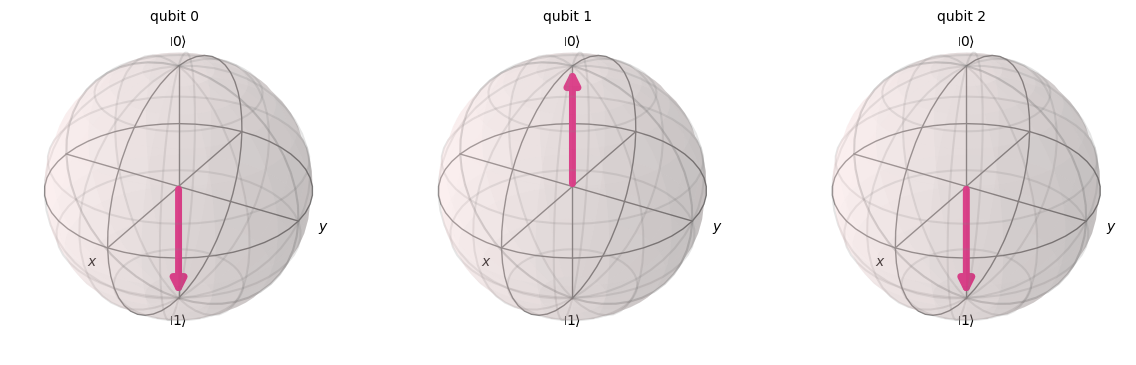

In [13]:
sim = AerSimulator()
qc_init = qc.copy()
qc_init.save_statevector()
statevector = sim.run([qc_init]).result().get_statevector()
plot_bloch_multivector(statevector)

Finally, let's use our QFT function and view the final state of our qubits:

In [14]:
qft(qc,3)
qc.draw()

┌───┐                                     ┌───┐   
q_0: ┤ X ├──────■──────────────────────■───────┤ H ├─X─
     └───┘      │                ┌───┐ │P(π/2) └───┘ │ 
q_1: ───────────┼────────■───────┤ H ├─■─────────────┼─
     ┌───┐┌───┐ │P(π/4)  │P(π/2) └───┘               │ 
q_2: ┤ X ├┤ H ├─■────────■───────────────────────────X─
     └───┘└───┘

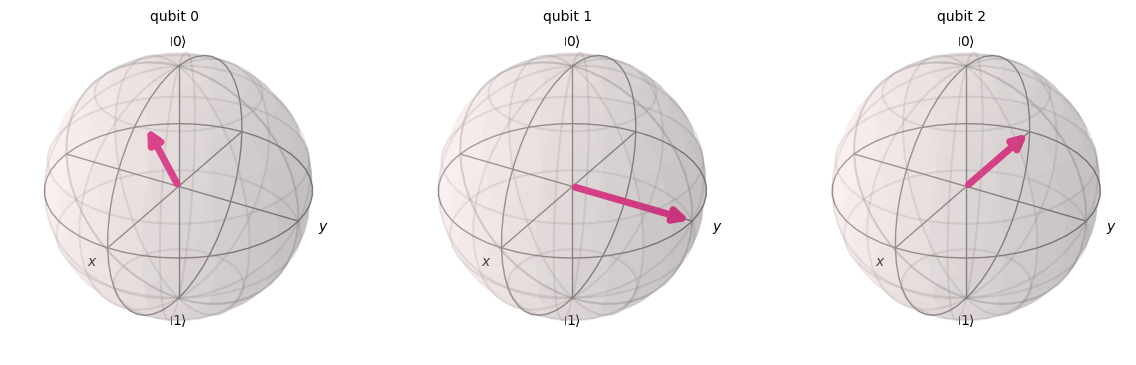

In [15]:
qc.save_statevector()
statevector = sim.run(qc).result().get_statevector()
plot_bloch_multivector(statevector)

We can see out QFT function has worked correctly. Compared the state $|\widetilde{0}\rangle = |{+}{+}{+}\rangle$, Qubit 0 has been rotated by $\tfrac{5}{8}$ of a full turn, qubit 1 by $\tfrac{10}{8}$ full turns (equivalent to $\tfrac{1}{4}$ of a full turn), and qubit 2 by $\tfrac{20}{8}$ full turns (equivalent to $\tfrac{1}{2}$ of a full turn).

### 8.3 INVERSE QFT to get Identity

If we tried running the circuit at the end of section 8.2 on a real device, the results would be completely random, since all qubits are in equal superposition of $|0\rangle$ and $|1\rangle$. If we want to demonstrate and investigate the QFT working on real hardware, we can instead create the state $|\widetilde{5}\rangle$ seen at the end of section 8.2, run the QFT in reverse, and verify the output is the state $|5\rangle$ as expected. 

Firstly, let’s use Qiskit to easily reverse our QFT operation:

In [16]:
def inverse_qft(circuit, n):
    invqft_circ = qft(QuantumCircuit(n), n).inverse()

    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit.decompose() # .decompose() allows us to see the individual gates

Now let's put our qubits in the state $|\widetilde{5}\rangle$:

In [17]:
nqubits = 3
number = 5
qc = QuantumCircuit(nqubits)
for qubit in range(nqubits):
    qc.h(qubit)
qc.p(number*pi/4,0)
qc.p(number*pi/2,1)
qc.p(number*pi,2)

qc.draw()

┌───┐┌─────────┐
q_0: ┤ H ├┤ P(5π/4) ├
     ├───┤├─────────┤
q_1: ┤ H ├┤ P(5π/2) ├
     ├───┤└┬───────┬┘
q_2: ┤ H ├─┤ P(5π) ├─
     └───┘ └───────┘

And we can see this does indeed result in the Fourier state $|\widetilde{5}\rangle$:

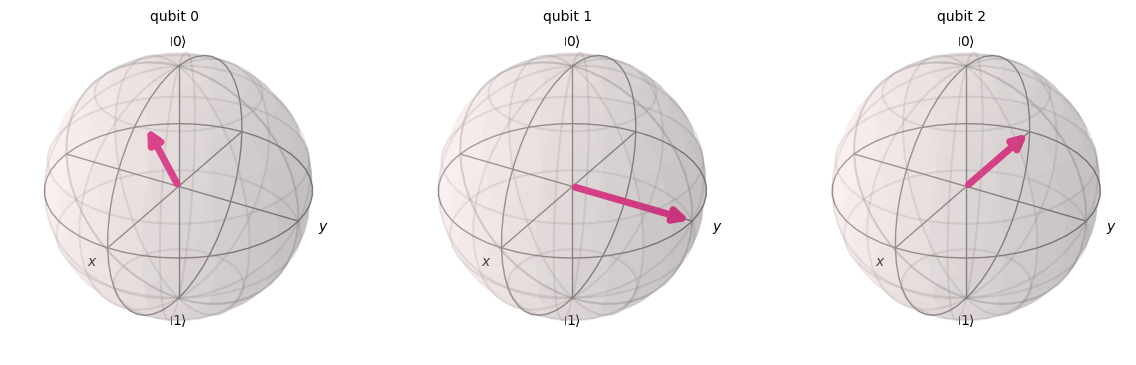

In [18]:
qc_init = qc.copy()
qc_init.save_statevector()
sim = AerSimulator()
statevector = sim.run(qc_init).result().get_statevector()
plot_bloch_multivector(statevector)

Finally, let's apply our inverse QFT:

In [19]:
qc.barrier()
qc = inverse_qft(qc, nqubits)
qc.measure_all()
qc.draw()

┌─────────┐┌─────────────┐ ░    ┌───┐                         »
   q_0: ┤ U2(0,π) ├┤ U(0,0,5π/4) ├─░──X─┤ H ├─■───────────────────────»
        ├─────────┤├─────────────┤ ░  │ └───┘ │P(-π/2) ┌───┐          »
   q_1: ┤ U2(0,π) ├┤ U(0,0,5π/2) ├─░──┼───────■────────┤ H ├─■────────»
        ├─────────┤└┬───────────┬┘ ░  │                └───┘ │P(-π/2) »
   q_2: ┤ U2(0,π) ├─┤ U(0,0,5π) ├──░──X──────────────────────■────────»
        └─────────┘ └───────────┘  ░                                  »
meas: 3/══════════════════════════════════════════════════════════════»
                                                                      »
«                        ░ ┌─┐      
«   q_0: ─■──────────────░─┤M├──────
«         │              ░ └╥┘┌─┐   
«   q_1: ─┼──────────────░──╫─┤M├───
«         │P(-π/4) ┌───┐ ░  ║ └╥┘┌─┐
«   q_2: ─■────────┤ H ├─░──╫──╫─┤M├
«                  └───┘ ░  ║  ║ └╥┘
«meas: 3/═══════════════════╩══╩══╩═
«                           0  1  2

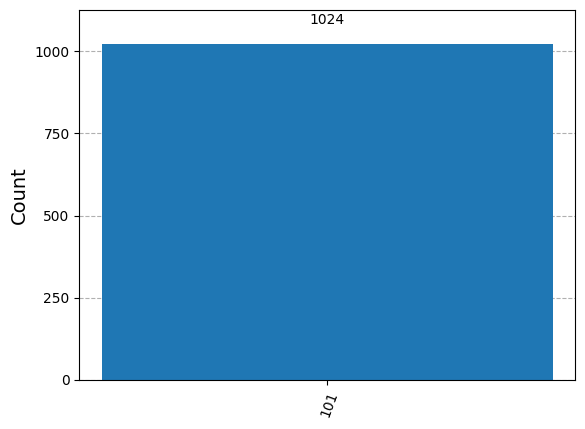

In [20]:
sim = AerSimulator()

result = sim.run([qc], shots=2**10).result()
measurements = result.get_counts()
plot_histogram(measurements)

We (hopefully) see that the highest probability outcome is $101$.